In [1]:
from qaoa_and_tdvp import QAOA, tdvp_optimize_qaoa, scipy_optimize, QAOAResult, Qobj
from MaxCut import MaxCut
from qutip import tensor
from qutip.qip.operations import expand_operator, rz
from benchmark import get_all_connected, get_connected_rn_graph, get_rn_qubo, select_if_connected, Benchmark
from qutip.parallel import parallel_map, serial_map
from itertools import combinations_with_replacement
from multiprocessing import Value
import pickle
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
p = 2
n=4
seed = 42
with open(f"./instances/n{n}_graphs.p","rb") as f:
    graphs = pickle.load(f)

In [3]:
index = 5#np.random.randint(0,len(graphs)); print(index)

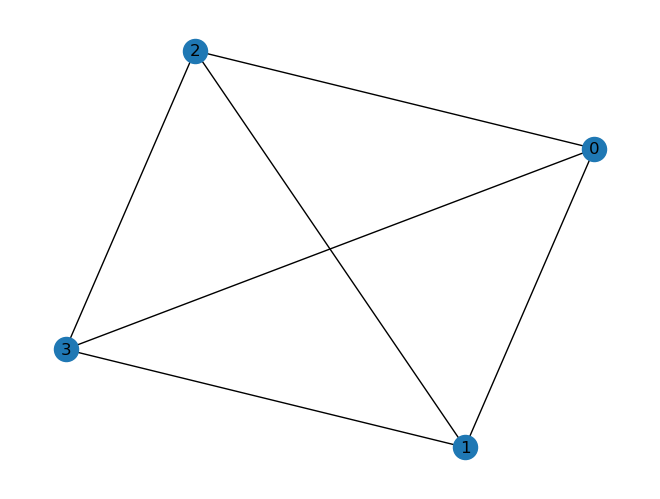

In [4]:
instance = MaxCut(graphs[index])
qaoa = QAOA(qubo=instance.qubo, p=p)
delta = tuple(1 for _ in range(2 * qaoa.p))

In [8]:
%timeit qaoa.gram(delta)

2.96 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
res = tdvp_optimize_qaoa(
    qaoa,
    delta,
    1,
    int_mode="RK45",
    rhs_mode="qaoa",
    grad_tol=0.1,
    max_iter=300,
)
print(res)

donestep 66


        tdvp_optimizer with circuit gradient evaluation and RK45 as integration mode terminated with sucess with message
        "The solver successfully reached the end of the integration interval."
        This took 221.06 seconds
        
            optimal parameters: (0.6446978559370611, 1.4820634690782613, 0.7971156265508911, 1.0024153539751348)
                 optimal value: 17.008301872041216
        maximal ground overlap: 0.7131465966023741
           number of fun calls: 56
               number of steps: 66
               number of gates: 1658514
        


In [41]:
sci_res = scipy_optimize(qaoa, delta)
sci_res


        scipy_cobyla terminated with sucess with message
        "Optimization terminated successfully."
        This took 5.25 seconds
        
            optimal parameters: [1.56733882 0.78449255 1.82667484 1.07586705]
                 optimal value: 17.261663823713175
        maximal ground overlap: 0.4518900748808219
           number of fun calls: 260
               number of steps: None
               number of gates: 7280
        